# Clustering-Based SHAP Networks for NHANES I dataset XGBoost Model

This notebook implements clustering-based aggregation to discover patient phenotypes with distinct disease mechanisms.

**Approach:** Cluster patients based on their SHAP value patterns, then build separate networks for each cluster. This may reveal distinct disease subtypes with different feature importance patterns and mechanisms.

**Mathematical Framework:**
- **Node weights** aggregate individual SHAP values across patients in each cluster
- **Edge weights** aggregate interaction values, with the denominator normalized using only the **lower triangular** interaction matrix (u > v), excluding diagonal elements

In [1]:
import os
import sys
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

from cgt_perezsechi.visualization.graph import draw
from cgt_perezsechi.manipulation.norm import normalize_psi, normalize_r

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configure matplotlib for VS Code Jupyter
%matplotlib inline

In [3]:
# Load data
X = pd.read_pickle("../../../../data/nhanesi/x_values.pkl")
num_patients = 500
X_shapley = X.iloc[:num_patients, :]
shap_values = np.load("../../../../data/nhanesi/xgboost/shap_values.npy")
shap_interaction_values = np.load("../../../../data/nhanesi/xgboost/shap_interaction_values.npy")

## Prepare SHAP Values for Clustering

In [4]:
shap_features = np.nan_to_num(shap_values)

# Standardize for clustering
scaler = StandardScaler()
shap_features_scaled = scaler.fit_transform(shap_features)

## Determine Optimal Number of Clusters

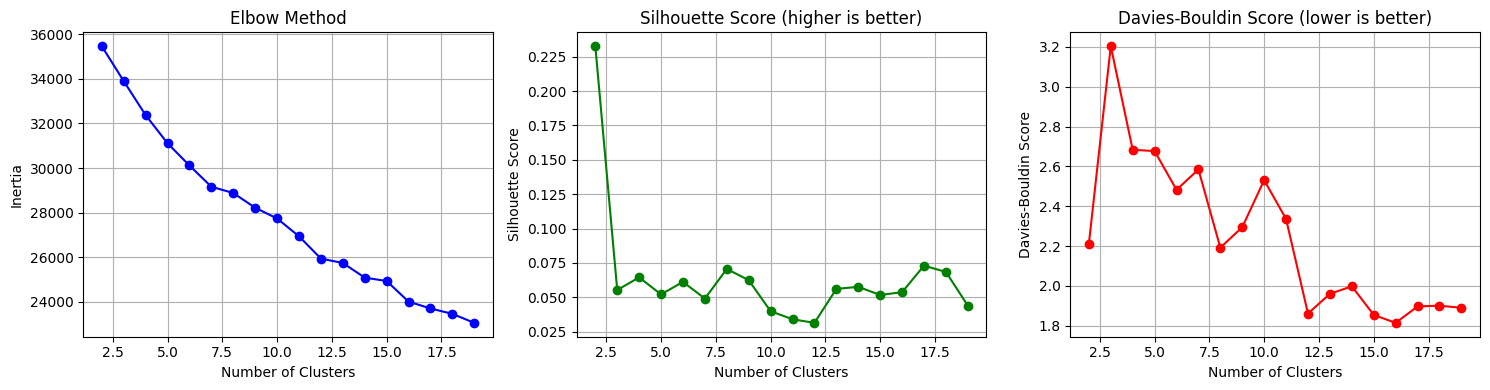


Clustering Metrics:
    n_clusters       inertia  silhouette  davies_bouldin
0            2  35462.585938    0.232586        2.210893
1            3  33899.363281    0.055328        3.203583
2            4  32373.263672    0.064548        2.683237
3            5  31111.123047    0.052166        2.676682
4            6  30115.000000    0.061253        2.482113
5            7  29162.654297    0.049131        2.584419
6            8  28882.148438    0.070643        2.191607
7            9  28219.953125    0.062494        2.294473
8           10  27739.148438    0.039943        2.530772
9           11  26941.339844    0.034098        2.335480
10          12  25941.761719    0.031458        1.860803
11          13  25744.835938    0.056177        1.959736
12          14  25089.392578    0.057650        1.997649
13          15  24936.611328    0.051737        1.854196
14          16  24013.785156    0.053774        1.813910
15          17  23706.480469    0.073057        1.896543
16        

In [5]:
# Test different numbers of clusters
k_range = range(2, 20)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(shap_features_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(shap_features_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(shap_features_scaled, labels))

# Plot elbow curve and metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(k_range, silhouette_scores, 'go-')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score (higher is better)')
axes[1].grid(True)

axes[2].plot(k_range, davies_bouldin_scores, 'ro-')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('Davies-Bouldin Score')
axes[2].set_title('Davies-Bouldin Score (lower is better)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Print metrics
metrics_df = pd.DataFrame({
    'n_clusters': list(k_range),
    'inertia': inertias,
    'silhouette': silhouette_scores,
    'davies_bouldin': davies_bouldin_scores
})
print("\nClustering Metrics:")
print(metrics_df)

## Perform Final Clustering

In [6]:
# Choose optimal k (you can adjust this based on the metrics above)
optimal_k = 4

# Perform final clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(shap_features_scaled)

# Display cluster sizes
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print(f"\nFinal clustering with k={optimal_k}:")
for cluster_id, size in cluster_sizes.items():
    print(f"  Cluster {cluster_id}: {size} patients ({size/num_patients*100:.1f}%)")


Final clustering with k=4:
  Cluster 0: 228 patients (45.6%)
  Cluster 1: 213 patients (42.6%)
  Cluster 2: 52 patients (10.4%)
  Cluster 3: 7 patients (1.4%)


## Function to Build Network for Cluster

**Key Implementation Details:**

The function implements the following equations from the paper:

**Node weights (N*_i):**
$$\mathcal{N}^*_i = \frac{\sum_{t \in C_c} Sh_{i}(\Delta^{t})}{\sum_{u=1}^{n} \sum_{t \in C_c} |Sh_{u}(\Delta^{t})|}$$

**Edge weights (E*_ij):**
$$\mathcal{E}^*_{ij} = \frac{\sum_{t \in C_c} I_{ij}(\Delta^{t})}{\sum_{v=1}^{n} \sum_{u > v}^{n} \sum_{t \in C_c} I_{uv}(\Delta^{t})}$$

where $C_c$ denotes the set of patients in cluster $c$.

**Important:** The edge weight denominator sums only over the **lower triangular** part of the interaction matrix (where u > v), excluding diagonal elements. This differs from summing over all non-diagonal elements.

In [7]:
def build_network_for_cluster(cluster_mask, shap_values, shap_interaction_values, X_shapley):
    """
    Build psi and r matrices for a specific cluster
    
    Implements equations:
    - Node weights: N*_i = sum_t(Sh_i) / sum_u sum_t |Sh_u|
    - Edge weights: E*_ij = sum_t(I_ij) / sum_v sum_{u>v} sum_t |I_uv|
      where u>v denotes the lower triangular matrix (excluding diagonal)
    """
    # Filter SHAP values for this cluster
    cluster_shap = shap_values[cluster_mask]
    cluster_interaction = shap_interaction_values[cluster_mask]
    
    # Calculate psi_1 (node weights)
    # Numerator: sum over patients for each feature
    # Denominator: sum of absolute values over all patients and all features
    sum_shap = np.sum(np.abs(cluster_shap), axis=(0, 1))
    psi_1 = pd.DataFrame()
    psi_1['value'] = np.sum(cluster_shap, axis=0) / sum_shap
    psi_1.set_index(X_shapley.columns, inplace=True)
    
    # Calculate r_1 (edge weights) - use only lower triangular matrix for denominator
    n_patients_cluster = cluster_interaction.shape[0]
    n_variables = cluster_interaction.shape[1]
    
    # Clean NaN values
    filtered_interaction = np.nan_to_num(cluster_interaction.copy())
    
    # Create lower triangular mask (u > v means row > col, excluding diagonal)
    lower_tri_mask = np.tril(np.ones((n_variables, n_variables), dtype=bool), k=-1)
    
    # Calculate denominator: sum of absolute values of lower triangular elements only
    # sum_v sum_{u>v} sum_t |I_uv(Delta^t)|
    sum_interaction_lower = 0.0
    for patient_idx in range(n_patients_cluster):
        sum_interaction_lower += np.sum(np.abs(filtered_interaction[patient_idx][lower_tri_mask]))
    
    # Calculate numerator: sum over patients for each (i,j) pair
    # sum_t I_ij(Delta^t)
    cumulative_interaction = np.sum(filtered_interaction, axis=0)
    
    # Zero out diagonal (remove self-interactions)
    np.fill_diagonal(cumulative_interaction, 0)
    
    # Calculate edge weights: E*_ij = numerator / denominator
    r_1 = pd.DataFrame(cumulative_interaction / sum_interaction_lower)
    r_1.rename(columns=dict(list(zip(r_1.columns, X_shapley.columns))), inplace=True)
    r_1.set_index(X_shapley.columns, inplace=True)
    
    # Normalize
    psi_2 = normalize_psi(psi_1)
    r_2 = normalize_r(r_1)
    
    return psi_1, r_1, psi_2, r_2

## Build Networks for Each Cluster

In [8]:
# Build networks for each cluster
cluster_networks = {}

for cluster_id in range(optimal_k):
    cluster_mask = cluster_labels == cluster_id
    psi_1, r_1, psi_2, r_2 = build_network_for_cluster(
        cluster_mask, shap_features, shap_interaction_values, X_shapley
    )
    cluster_networks[cluster_id] = {
        'psi_1': psi_1,
        'r_1': r_1,
        'psi_2': psi_2,
        'r_2': r_2,
        'n_patients': cluster_mask.sum()
    }
    print(f"Cluster {cluster_id} network built ({cluster_mask.sum()} patients)")

Cluster 0 network built (228 patients)
Cluster 1 network built (213 patients)
Cluster 2 network built (52 patients)
Cluster 3 network built (7 patients)


## Visualization Setup

In [9]:
shap_cmap = shap.plots.colors.red_blue
positive_color = shap_cmap(0.0)[:3]
negative_color = shap_cmap(1.0)[:3]

positive_alpha = 0.05
negative_alpha = 0.05
positive_beta = 0
negative_beta = 0

## Visualize All Cluster Networks


Cluster 0 Network (228 patients)
Saving the graph to ..\..\..\..\result\nhanesi_xgboost_cluster_0_network.jpg


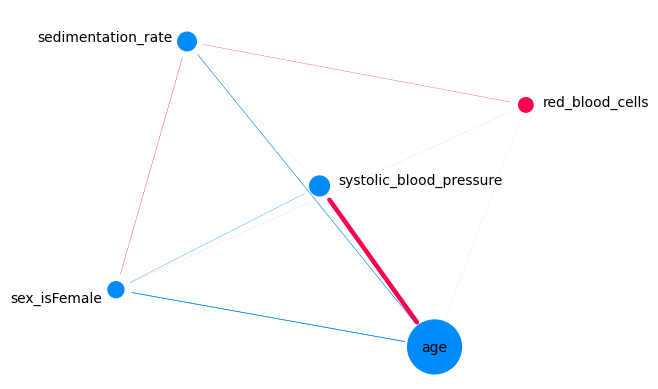


Cluster 1 Network (213 patients)
Saving the graph to ..\..\..\..\result\nhanesi_xgboost_cluster_1_network.jpg


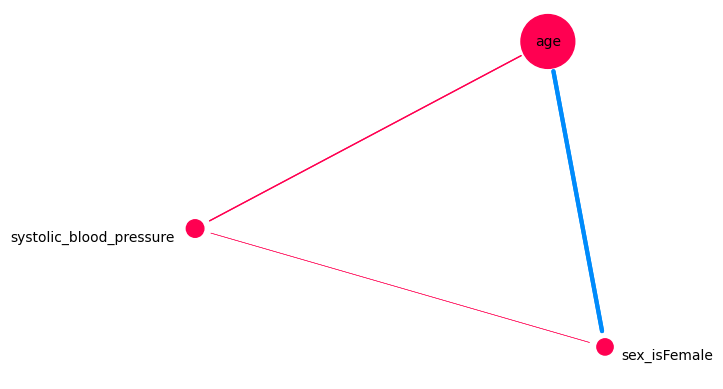


Cluster 2 Network (52 patients)
Saving the graph to ..\..\..\..\result\nhanesi_xgboost_cluster_2_network.jpg


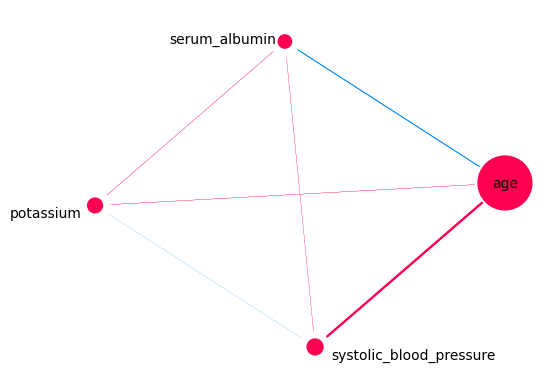


Cluster 3 Network (7 patients)
Saving the graph to ..\..\..\..\result\nhanesi_xgboost_cluster_3_network.jpg


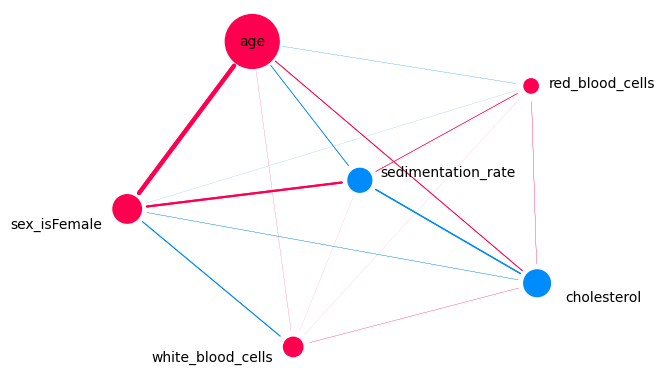

In [10]:
import warnings

warnings.filterwarnings('ignore')

for cluster_id in range(optimal_k):
    print(f"\n{'='*60}")
    print(f"Cluster {cluster_id} Network ({cluster_networks[cluster_id]['n_patients']} patients)")
    print('='*60)
    
    draw(
        psi=cluster_networks[cluster_id]['psi_2'],
        r=cluster_networks[cluster_id]['r_2'],
        positive_alpha=positive_alpha,
        negative_alpha=negative_alpha,
        positive_beta=positive_beta,
        negative_beta=negative_beta,
        negative_color=negative_color,
        positive_color=positive_color,
        label_color='black',
        label_weight='normal',
        plot_margin=0.05,
        output_path=os.path.join('..', '..', '..','..', 'result', f'nhanesi_xgboost_cluster_{cluster_id}_network.jpg')
    )

## Comparative Analysis: Top Features by Cluster

In [11]:
# Compare top features across clusters
def get_top_features(psi, n=10):
    return psi['value'].abs().nlargest(n)

print("\nTop 10 Features by Cluster Phenotype:\n")
for cluster_id in range(optimal_k):
    print(f"CLUSTER {cluster_id} ({cluster_networks[cluster_id]['n_patients']} patients):")
    top_features = get_top_features(cluster_networks[cluster_id]['psi_1'])
    for idx, (feature, value) in enumerate(top_features.items(), 1):
        print(f"  {idx}. {feature}: {value:.4f}")
    print()


Top 10 Features by Cluster Phenotype:

CLUSTER 0 (228 patients):
  1. age: 1.0000
  2. systolic_blood_pressure: 0.1346
  3. sedimentation_rate: 0.1189
  4. sex_isFemale: 0.0875
  5. red_blood_cells: 0.0723
  6. serum_albumin: 0.0497
  7. cholesterol: 0.0447
  8. serum_protein: 0.0431
  9. bmi: 0.0264
  10. uric_acid: 0.0228

CLUSTER 1 (213 patients):
  1. age: 1.0000
  2. systolic_blood_pressure: 0.1063
  3. sex_isFemale: 0.0915
  4. red_blood_cells: 0.0289
  5. white_blood_cells: 0.0265
  6. bmi: 0.0167
  7. physical_activity: 0.0148
  8. uric_acid: 0.0139
  9. serum_protein: 0.0137
  10. sedimentation_rate: 0.0109

CLUSTER 2 (52 patients):
  1. age: 1.0000
  2. systolic_blood_pressure: 0.0868
  3. potassium: 0.0748
  4. serum_albumin: 0.0609
  5. SGOT: 0.0496
  6. sedimentation_rate: 0.0389
  7. red_blood_cells: 0.0363
  8. hematocrit: 0.0215
  9. hemoglobin: 0.0200
  10. uric_acid: 0.0177

CLUSTER 3 (7 patients):
  1. age: 1.0000
  2. sex_isFemale: 0.2788
  3. cholesterol: 0.2461
 